In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageChops,ImageEnhance
from glob import glob

In [2]:
total_files = glob("casia\CASIA2/**/*")
print(len(total_files))


12616


In [3]:
type=set()
for file in total_files:
    type.add(file.split(".")[-1])
print("types of files are",type)

types of files are {'db', 'bmp', 'JPG', 'jpg', 'tif'}


In [4]:
jpg_images=glob("casia\CASIA2/**/*.jpg")
print('the number of jpg images are:',len(jpg_images))

the number of jpg images are: 9501


In [5]:
tif_images=glob("casia\CASIA2/**/*.tif")
print("the number of tif images are:",len(tif_images))

the number of tif images are: 3059


In [6]:
bmp_images=glob("casia\CASIA2/**/*.bmp")
print("the number of bmp images are:",len(bmp_images))

the number of bmp images are: 54


In [7]:
def convert_to_ela_image(path, quality=90):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

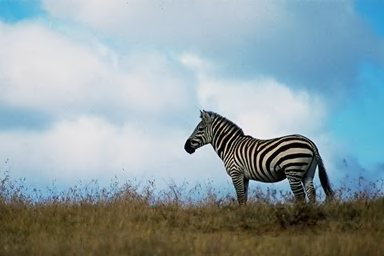

In [8]:
real_image_path=r"casia\CASIA2/Au/Au_ani_00001.jpg"
Image.open(real_image_path) 

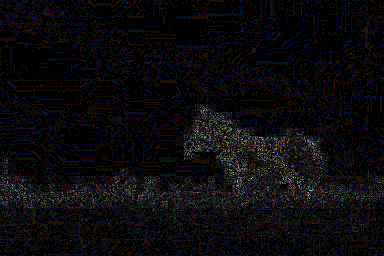

In [9]:
convert_to_ela_image(real_image_path, 90)

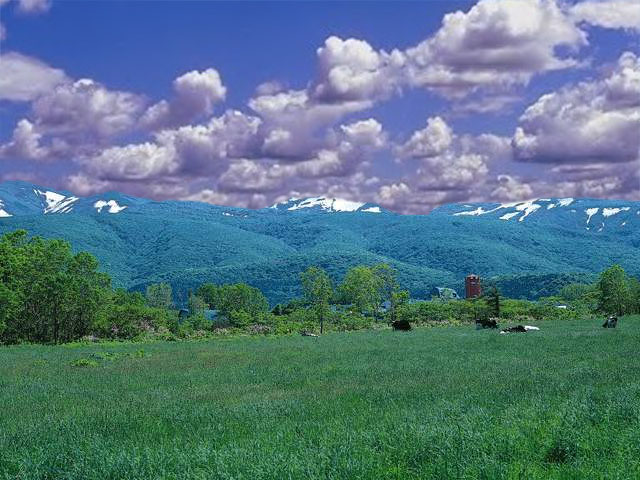

In [10]:
forged_img_path=r"casia\CASIA2/Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg"
Image.open(forged_img_path)

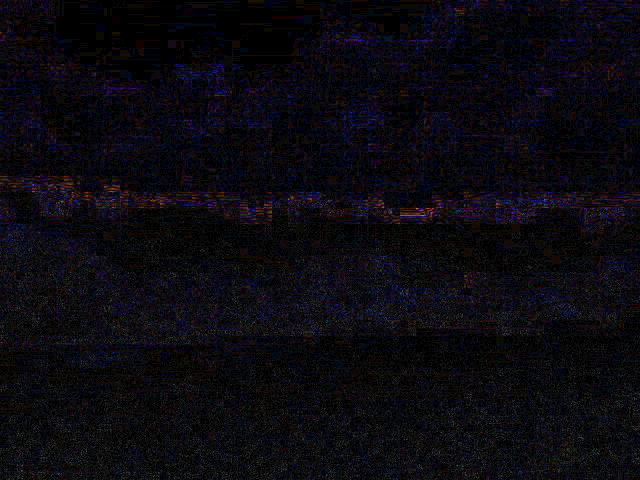

In [11]:
convert_to_ela_image(forged_img_path, 90)

In [12]:
images=jpg_images
print('jpeg files',len(images))
print('tif_files',len(tif_images))

jpeg files 9501
tif_files 3059


In [13]:
def findfiles(files):
    tp_files,au_files=0, 0
    for file in files:
        if file.split("/")[-2]=="Tp":
            tp_files+=1
        if file.split("/")[-2]=="Au":
            au_files+=1
    return tp_files,au_files
    


In [14]:
image_size=(128,128)

In [15]:
print(findfiles(images))

IndexError: list index out of range

In [16]:
def preprocessing(image_path):
    return np.array(convert_to_ela_image(image_path,90).resize(image_size)).flatten()/255

In [17]:
import random
import os
import numpy as np
X=[]
Y=[]
path="casia\CASIA2/Au"
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:5000]
Y = Y[:5000]
print(len(X), len(Y))

5000 5000


In [18]:
v=0
path ="casia\CASIA2/Tp"
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
            v+=1
print(len(X), len(Y))
print(v)

10123 10123
5123


In [19]:
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical
Y = to_categorical(Y, 2)
Y.shape

(10123, 2)

In [20]:
from sklearn.model_selection import train_test_split
X_train_test,X_val,Y_train_test,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X_train,X_test,Y_train,Y_test=train_test_split(X_train_test,Y_train_test,test_size=0.25,random_state=2)
print(len(X_train), len(Y_train))
print(len(X_test),len(Y_test))
print(len(X_val), len(Y_val))

6073 6073
2025 2025
2025 2025


In [21]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import MaxPooling2D,AveragePooling2D
from keras.layers import Dense, Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [22]:
def CNN():
    model=Sequential()
    model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(128,128,3)))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=2,activation='softmax'))
    return model

In [23]:
model=CNN()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 average_pooling2d (Average  (None, 62, 62, 128)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 256)       819456    
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 256)       0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 64)                

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=20,batch_size=32)


Epoch 1/20


190/190 [==============================] - 802s 4s/step - loss: 0.6011 - accuracy: 0.7092 - val_loss: 0.4091 - val_accuracy: 0.8583
Epoch 2/20
190/190 [==============================] - 752s 4s/step - loss: 0.4609 - accuracy: 0.8166 - val_loss: 0.4226 - val_accuracy: 0.8153
Epoch 3/20
190/190 [==============================] - 731s 4s/step - loss: 0.4187 - accuracy: 0.8376 - val_loss: 0.3319 - val_accuracy: 0.8775
Epoch 4/20
190/190 [==============================] - 742s 4s/step - loss: 0.3969 - accuracy: 0.8554 - val_loss: 0.4639 - val_accuracy: 0.7990
Epoch 5/20
190/190 [==============================] - 742s 4s/step - loss: 0.3878 - accuracy: 0.8539 - val_loss: 0.3241 - val_accuracy: 0.8760
Epoch 6/20
190/190 [==============================] - 737s 4s/step - loss: 0.3577 - accuracy: 0.8712 - val_loss: 0.3450 - val_accuracy: 0.8627
Epoch 7/20
190/190 [==============================] - 732s 4s/step - loss: 0.3898 - accuracy: 0.8553 - val_loss: 0.3727 - val_accuracy: 0.8

In [25]:
loss,accuracy=model.evaluate(X_test, Y_test)

64/64 [==============================] - 77s 1s/step - loss: 0.2306 - accuracy: 0.9190


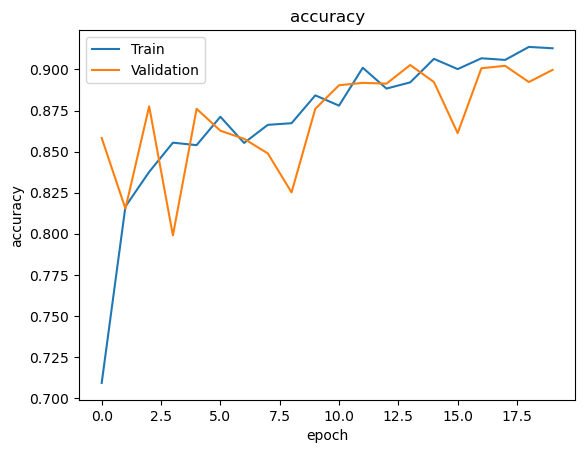

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])
plt.show()

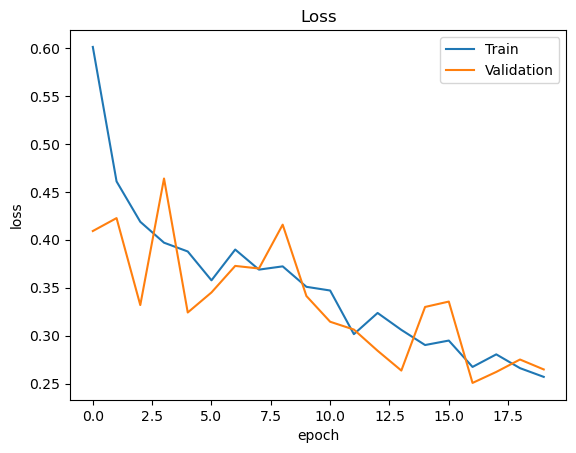

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Validation'])
plt.show()

64/64 [==============================] - 80s 1s/step


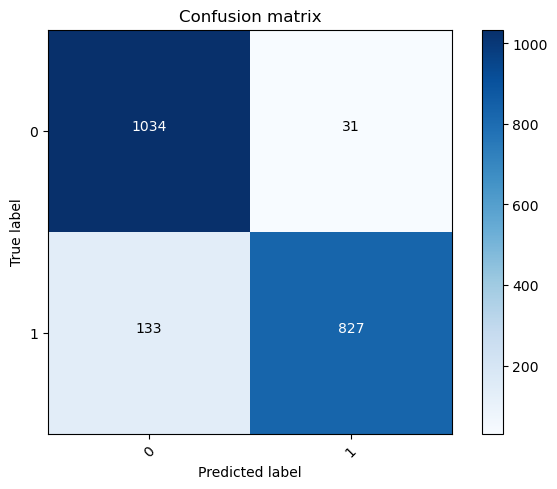

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [29]:
model.save("imageforgerymodelkaggle.h5")
from tensorflow.keras.models import load_model
laodedmodel=load_model("imageforgerymodelkaggle.h5")
laodedmodel.summary()

c:\Users\Rajiv\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 average_pooling2d (Average  (None, 62, 62, 128)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 256)       819456    
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 256)       0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [30]:
from tensorflow.keras.models import load_model
model.save("proj.h5")

c:\Users\Rajiv\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
